# Removing Effect of Sensor Depth Spill
This notebook is meant to illustrate the current state of trying to remove the effect of sensor depth spill. 

## Part 1 - Load/Define

In [1]:
import os, json
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage

rootdir = '/data/staff/common/data/pd'
datafilename = 'LaB6_ref_carmen_data_000001.h5'
filename = os.path.join(rootdir,datafilename)
data_path = '/entry/data/data'

with h5py.File(filename,'r') as h5f:
    data = h5f[data_path][()]
    data = np.squeeze(data)

#Removing raw parts of image: 
#-1 -> detector gaps, -2 -> hot pixels + extreme values
mask = np.logical_or(data==np.uint32(-1),data==np.uint32(-2))
img = data.copy()
img[mask] = 0
mask = ~mask

#Is this step ok to do?
img_smooth = ndimage.uniform_filter(img, size=3)

#Parameters
pl = 75  # pixel length, in micrometers 
pw = 450 # pixel width, in micrometers
ph = 75  # pixel height, in micrometers
sx = -0.15440269217351899 * 10**6 # -dist in poni file, in micrometers
sy =  0.09233769557958088 * 10**6 # P2 in poni file, in micrometers
sz =  0.01614699850343882 * 10**6 # P1 in poni file, in micrometers
wlen = 0.9537204867449691 # Wavelength in Å
# in pixel coordinates
sy_pix = sy/pl
sz_pix = sz/ph

## Correction of Sensor Depth Spill


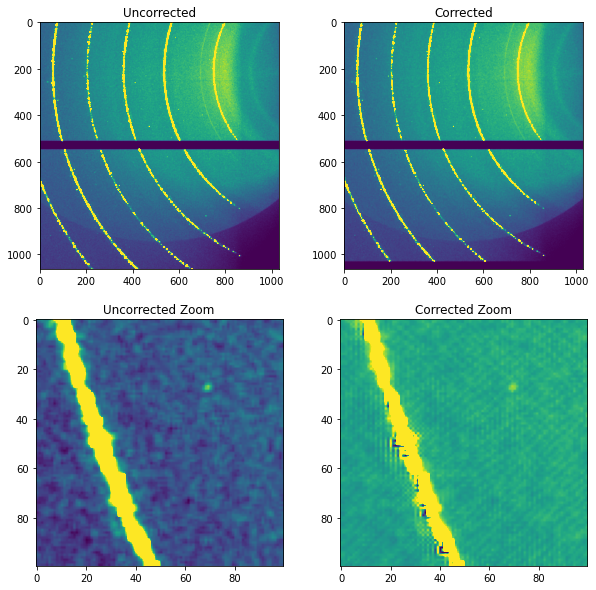

In [2]:
from cupy import meshgrid, linspace
import numpy as np
import cupy as cp
import xtrace

#Hit points
samp = 1
hit_col, hit_row = meshgrid(
    linspace(0, img.shape[0], round(samp*img.shape[0])),
    linspace(0, img.shape[1], round(samp*img.shape[1]))
)
hit_row = hit_row.flatten()
hit_col = hit_col.flatten()

#Point spread function generation
G = xtrace.sensor_depth_spill_psf({
    "mu": 3.445930 * 10**-3, #in 1/micron
    "IO": 1,
    #Pixel dimentions
    "pl": pl,
    "pw": pw,
    "ph": ph,
    #Detector dimentions
    "det_numpixels": img.shape,
    #detector limits in Cartesian coordinates
    "det_xlim": (0.0, pw),
    "det_ylim": (0.0, img.shape[1] * pl),
    "det_zlim": (0.0, img.shape[0] * ph),
    #Cartesian coordinates of the sample, given by the poni file 
    "sx": sx,
    "sy": sy,
    "sz": sz,
    #Positive or negative integer number related to the plane point
    "Jj": 10,
}, hit_row, hit_col)

#Recover image, using regularized richard lucy deconvolution
recovered_img = xtrace.regularized_richard_lucy_deconv(img_smooth, G, 0.05, 100).get()

perc = np.percentile(img_smooth, 98)
area = (slice(400,500), slice(550,650))
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].set_title("Uncorrected")
axs[0, 0].imshow(img_smooth, vmax=perc) # r_n_perc
axs[0, 1].set_title("Corrected")
axs[0, 1].imshow(recovered_img, vmax=perc) # r_n_perc
axs[1, 0].set_title("Uncorrected Zoom")
axs[1, 0].imshow(img_smooth[area], vmax=perc)
axs[1, 1].set_title("Corrected Zoom")
axs[1, 1].imshow(recovered_img[area], vmax=perc)
plt.show()

## Azimuthal Integration
Comparison between raw and reconstructed

In [3]:
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
import maxpy_erda as mp

# we actually see 6 LaB6 lines and so we take only them
# note: some lines still may be there multiple times (in case they overlap)
nhkl = 6
icsd_tbl = np.loadtxt(os.path.join(rootdir,'LaB6-icsd.txt'), skiprows=1)
hkl = icsd_tbl[:,0:3].astype(np.int32)
alat = 4.156468 # Å (tabulated)
# interplanar distances
d_hkl = alat/np.sqrt((hkl**2).sum(axis=1))
# peak positions in 2Theta (Bragg's law)
arg = wlen/2./d_hkl
lidx = arg<=1. # some reflections may be unreachable for our wavelength
d_hkl = d_hkl[lidx]
arg = arg[lidx]
tth_hkl = 2.*np.arcsin(wlen/2./d_hkl)
# we actually see 6 LaB6 lines and so we take only them
# note: some lines still may be there multiple times (in case they overlap)
hkl = hkl[:nhkl,:]
d_hkl = d_hkl[:nhkl]
tth_hkl = tth_hkl[:nhkl]
hkl = hkl[:nhkl,:]
d_hkl = d_hkl[:nhkl]
tth_hkl = tth_hkl[:nhkl]

deg2rad = np.pi/180.
rad2deg = 180./np.pi

ai = AzimuthalIntegrator() # new integrator
ai.setPyFAI(pixel1=ph*1e-6, pixel2=pl*1e-6,
            dist=0.15440269217351899,
            poni1=0.01614699850343882, poni2=0.09233769557958088,
            rot1=0., rot2=0., rot3=0.,
            splineFile=None)

# convert detector parameters from Carmen's (pyFAI-like) notation to bli711 (Fit2D-like) notation
pf2d = ai.getFit2D()
det_params_b711 = { 'n0': pf2d['centerY'], 'm0': pf2d['centerX'], \
                    'wn': (pf2d['pixelY']*1e-3/pf2d['directDist']), 'wm': (pf2d['pixelX']*1e-3/pf2d['directDist']), \
                    'phi': 0*np.pi/2, \
                    'n': data.shape[0], 'm': data.shape[1], \
                    'rot': pf2d['tiltPlanRotation']*deg2rad , 'tilt': pf2d['tilt']*deg2rad }

xtth = np.linspace(0.0, 36*deg2rad, int(36./0.01)+1) # dxtth=0.02 deg
tthFnc_tilt = mp.tth2DwithTilt
tthFnc = mp.tth2Dsimple

_idx_split, _wgt_split = \
    mp.ttheq_get_indexes_withPixelSplitting(xtth, delta=0.0,
                                            detParams=det_params_b711,
                                            N=[],M=[],
                                            tthFnc=tthFnc)

_nbvpix = np.sum((_wgt_split>0).astype('uint32'))

# for compatibility with FPGA
fptp = np.dtype(np.float32)
_idx_split = _idx_split.astype(np.int16)
_wgt_split = _wgt_split.astype(fptp)

def integrate(img):
    idata_bc = np.zeros(xtth.shape, dtype=fptp)
    ndata_bc = np.zeros(xtth.shape, dtype=fptp)
    for k in range(_idx_split.shape[-1]):
       # reduce data
       _lidx  = _wgt_split[:,:,k]>0.
       _ridx  = _idx_split[_lidx,k]
       _rimg  = img[_lidx]*_wgt_split[_lidx,k]
       _rmask = mask[_lidx]*_wgt_split[_lidx,k]
       # integrate data
       idata_bc += np.bincount(_ridx,weights=_rimg,minlength=len(xtth))
       ndata_bc += np.bincount(_ridx,weights=_rmask,minlength=len(xtth))
    inorm_bc = np.full_like(xtth,np.nan)
    lidx = ndata_bc>0
    inorm_bc[lidx] = idata_bc[lidx]/ndata_bc[lidx]
    return inorm_bc

az_img_smooth = integrate(img_smooth)
az_recovered = integrate(recovered_img)
deg_xtth = xtth*rad2deg
    

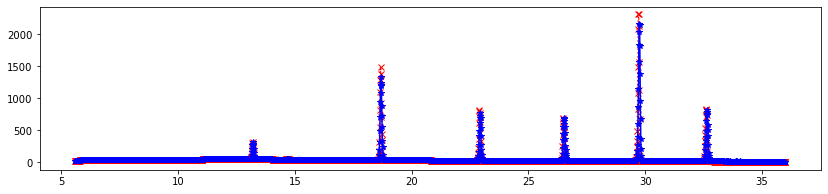

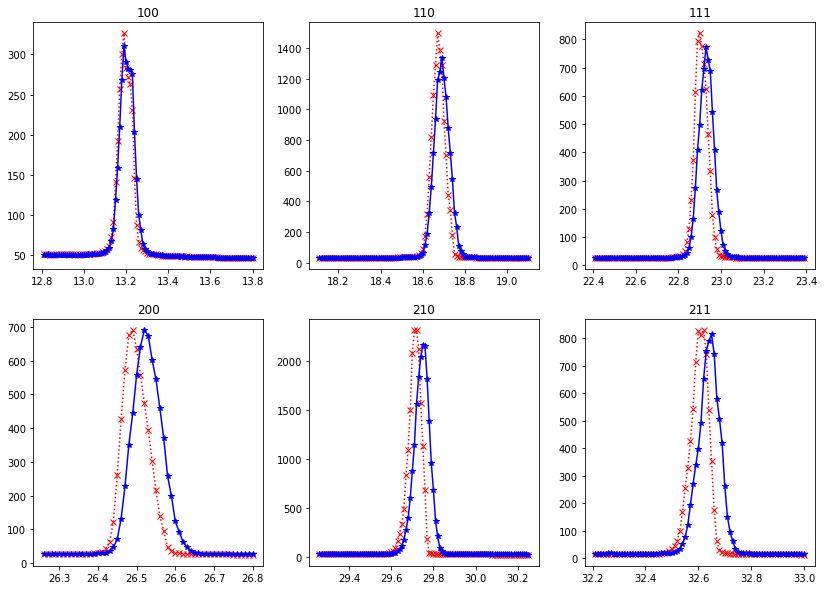

In [4]:
import math

peaks = {
    "100": (12.8, 13.8),
    "110": (18.1, 19.1),
    "111": (22.4, 23.4),
    "200": (26.25, 26.8),
    "210": (29.25, 30.25),
    "211": (32.2, 33.0)
}

peak_slices = {name:np.logical_and(b1 < deg_xtth, deg_xtth < b2) 
               for name, (b1, b2) in peaks.items()}

# show integrated data
plt.figure(figsize=(14,3))
plt.plot(deg_xtth, az_recovered, "r:x")
plt.plot(deg_xtth, az_img_smooth, "b-*")

fig, axs = plt.subplots(2, 3, figsize=(14,10))

for i, (name, slc) in enumerate(peak_slices.items()):
    j, k = (math.floor(i/3), i%3)
    axs[j,k].plot(deg_xtth[slc], az_recovered[slc], "r:x")
    axs[j,k].plot(deg_xtth[slc], az_img_smooth[slc], "b-*")
    axs[j,k].set_title(name)

--------------------
--------------------
--------------------
--------------------
--------------------
--------------------


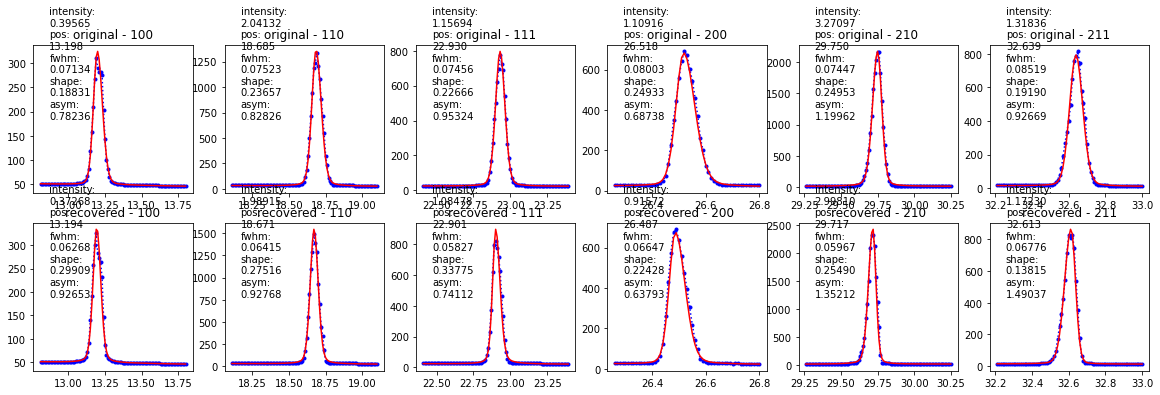

In [13]:
from fit_asym_voigt import fit
import itertools

stages = {"original": az_img_smooth, "recovered": az_recovered}
fig, axs = plt.subplots(2, 6, figsize=(20,6))
for p, (peak_name, mask) in enumerate(peak_slices.items()):
    for i, (src_name, az_src) in enumerate(stages.items()):
        peak_fit, p1 = fit(xtth[mask], az_src[mask])
        axs[i,p].plot(deg_xtth[mask], az_src[mask], 'b:.')
        axs[i,p].plot(deg_xtth[mask], peak_fit, 'r')
        axs[i,p].set_title(f'{src_name} - {peak_name}')
        axs[i,p].annotate(f'intensity:\n{p1[0]:.5f}\npos:\n{p1[1]*rad2deg:.3f}\nfwhm:\n'\
              f'{p1[2]*rad2deg:.5f}\nshape:\n{p1[3]:.5f}\nasym:\n{p1[4]:.5f}',
                xy=(0.1, 0.5),
                xycoords='axes fraction')
    print("-"*20)